📌 End To End Steps¶

1️⃣ Load & Explore Data – Import Quarterly EPS dataset, preprocess, and visualize.

2️⃣ Train-Test Split – Split time series correctly (no shuffling).

3️⃣ Analyze - plot ACF/PACF.

4️⃣ Achieve Stationarity – Apply differencing, ADF test

5️⃣ Baseline Models – Compare with historical mean & last-value models.

6️⃣ Fit AR Model – Select lag order, train AR(p)I(d) MA(q)

7️⃣ Evaluate Performance – Compare with baselines using MAE

8️⃣ Forecast Future Data – Predict and visualize Next Quarter EPS Data.

In [331]:
# 🔹 Step 1: Import Libraries & Load Data

In [332]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_error

from scipy.stats import boxcox

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [333]:
df = pd.read_csv('data/eps_quarter.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [335]:
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index
df.set_index('date', inplace=True)


# Display the dataframe
df.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [336]:
df.tail()

,data
date,
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


# 🔹 Step 2: Data Analysis And Visualization

## 📌 Plot the Time Series Data

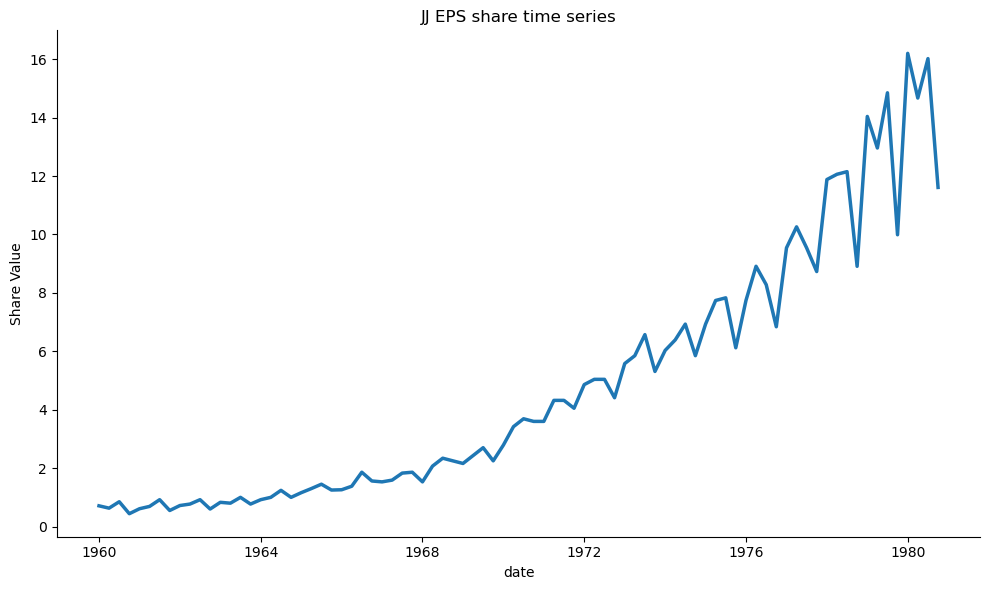

In [337]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['data'])
plt.title('JJ EPS share time series')

plt.xlabel('date')
plt.ylabel('Share Value')

plt.tight_layout()
plt.show()

## Decompose To Analyse Trend and Seasonality

In [338]:
# decomposition = STL(df['data'], period=4).fit()

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

# ax1.plot(decomposition.observed)
# ax1.set_ylabel('Observed')

# ax2.plot(decomposition.trend)
# ax2.set_ylabel('Trend')

# ax3.plot(decomposition.seasonal)
# ax3.set_ylabel('Seasonal')

# ax4.plot(decomposition.resid)
# ax4.set_ylabel('Residuals')

# # plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

# fig.autofmt_xdate()
# plt.tight_layout()

## Check for Stationarity (Dickey-Fuller Test)

In [339]:
# ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series, autolag='AIC')

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")

In [340]:
adf_test(df['data'])


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic  2.742017
               p-value  1.000000
           # Lags Used 11.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 1.00000 > 0.05)


# 🔹 Step 3: Train-Test Split

In [341]:

train_size = int(len(df) * 0.9)  # 90% training, 10% testing
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [342]:
print(f"Training Size: {len(train)} years")
print(f"Test Size: {len(test)} years")

Training Size: 75 years
Test Size: 9 years


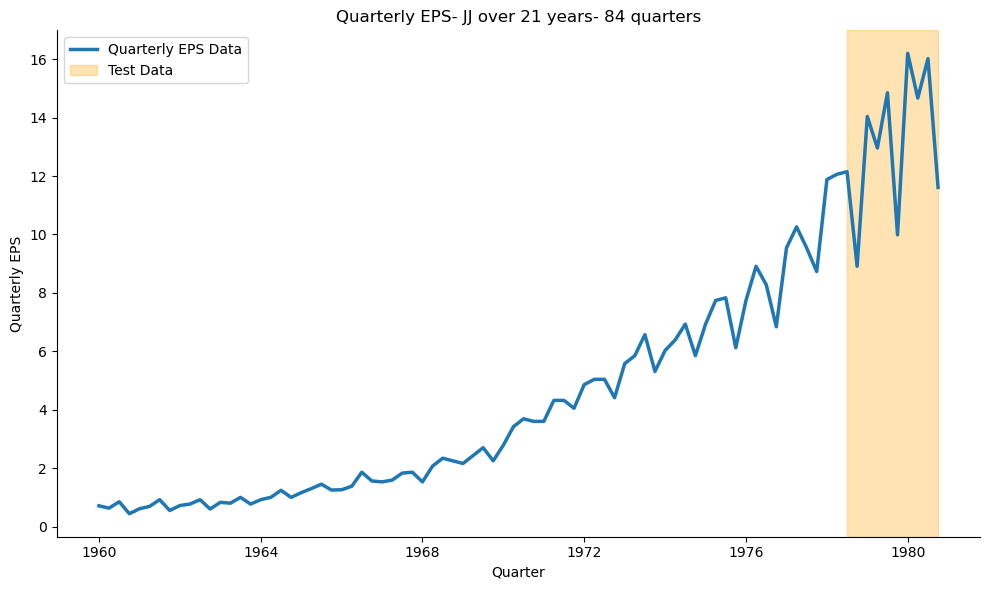

In [343]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['data'], label='Quarterly EPS Data')

# Highlight the period corresponding to the test data
plt.axvspan(train.index[-1], df.index[-1], color='orange', alpha=0.3, label='Test Data')

# Add labels, title, and show legend
plt.xlabel('Quarter')
plt.ylabel('Quarterly EPS')
plt.title('Quarterly EPS- JJ over 21 years- 84 quarters')
plt.legend()

plt.tight_layout()
plt.show()

# 🔹 Step 4:Create Baseline Models - Historic Mean, Last Value

In [344]:
historical_mean=np.mean(train['data'])

In [345]:
test = test.copy() 
test.loc[:, 'pred_mean'] = historical_mean
test

,data,pred_mean
date,,
1978-10-01,8.91,3.785733
1979-01-01,14.04,3.785733
1979-04-02,12.96,3.785733
1979-07-02,14.85,3.785733
1979-10-01,9.99,3.785733
1980-01-01,16.20,3.785733
1980-04-01,14.67,3.785733
1980-07-02,16.02,3.785733
1980-10-01,11.61,3.785733


## Create Last Known Value

In [346]:
last = train['data'].iloc[-1]
last

12.15

In [347]:
test.loc[:, 'pred_last'] = last
test

,data,pred_mean,pred_last
date,,,
1978-10-01,8.91,3.785733,12.15
1979-01-01,14.04,3.785733,12.15
1979-04-02,12.96,3.785733,12.15
1979-07-02,14.85,3.785733,12.15
1979-10-01,9.99,3.785733,12.15
1980-01-01,16.20,3.785733,12.15
1980-04-01,14.67,3.785733,12.15
1980-07-02,16.02,3.785733,12.15
1980-10-01,11.61,3.785733,12.15


In [348]:
# Calculate MAE for pred_mean
mae_mean = mean_absolute_error(test["data"], test["pred_mean"])

# Calculate MAE for pred_last
mae_last = mean_absolute_error(test["data"], test["pred_last"])

# Print results
print(f"MAE for pred_mean: {mae_mean:.3f}")
print(f"MAE for pred_last: {mae_last:.3f}")

MAE for pred_mean: 9.464
MAE for pred_last: 2.420


# 🔹 Step 4:Create ARMA Model

## Elimination of Non Stationarity

### Apply differencing

In [349]:
# create a differenced series
def trend_difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

In [350]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [351]:
# Apply differencing on just one column, assuming 'inflation' is the column of interest
eps_diff = trend_difference(df['data'].values, interval=1)

### Adfuller test to check stationarity of differenced series

In [352]:
adf_test(eps_diff)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -0.407410
               p-value  0.908854
           # Lags Used 10.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.90885 > 0.05)


In [353]:
eps_diff2 = eps_diff = trend_difference(eps_diff, interval=1)


In [354]:
adf_test(eps_diff2)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric     Value
        Test Statistic -3.585163
               p-value  0.006051
           # Lags Used  9.000000
Number of Observations 72.000000
   Critical Value (1%) -3.524624
   Critical Value (5%) -2.902607
  Critical Value (10%) -2.588679

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00605 ≤ 0.05)


In [355]:
# decomposition = STL(eps_diff2, period=4).fit()

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

# ax1.plot(decomposition.observed)
# ax1.set_ylabel('Observed')

# ax2.plot(decomposition.trend)
# ax2.set_ylabel('Trend')

# ax3.plot(decomposition.seasonal)
# ax3.set_ylabel('Seasonal')

# ax4.plot(decomposition.resid)
# ax4.set_ylabel('Residuals')

# # plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

# fig.autofmt_xdate()
# plt.tight_layout()

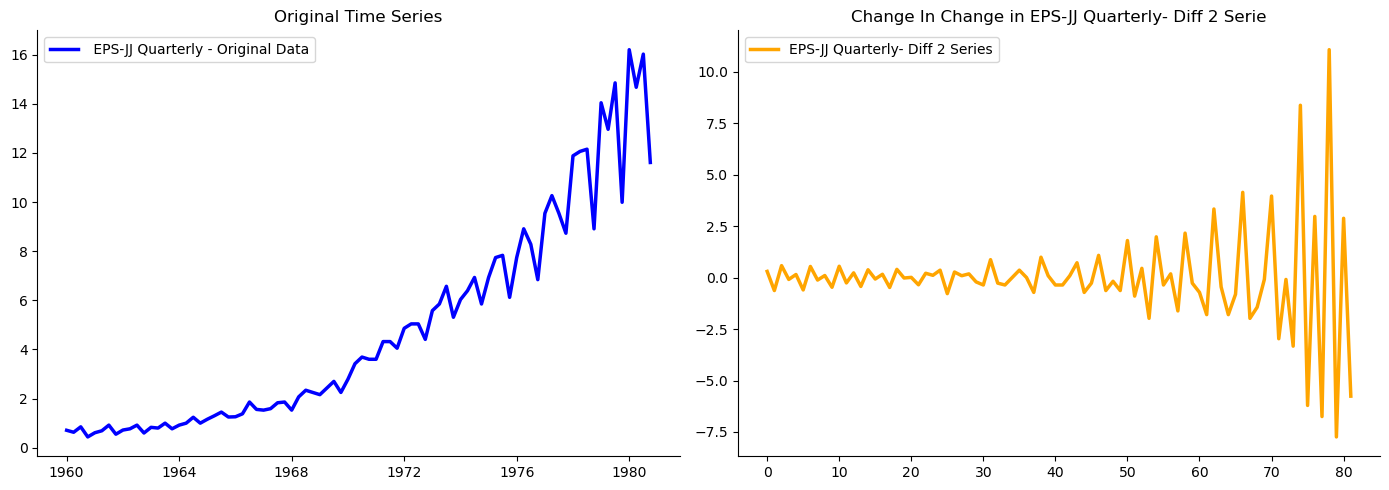

In [356]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label=' EPS-JJ Quarterly - Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Box-Cox transformed series
axes[1].plot(eps_diff2, label="EPS-JJ Quarterly- Diff 2 Series", color='orange')
axes[1].set_title('Change In Change in EPS-JJ Quarterly- Diff 2 Serie')
axes[1].legend()

plt.tight_layout()
plt.show()

In [357]:
# df_diff = pd.DataFrame({'eps_diff2': eps_diff2})

# train_diff = df_diff[:int(0.9*len(df_diff))]
# test_diff = df_diff[int(0.9*len(df_diff)):]


# print(len(train))
# print(len(test))

In [358]:
# TRAIN_LEN = len(train)
# HORIZON = len(test)

## Determine Lag Order (p,q,d=2)

### ACF PACF for Initial Analysis

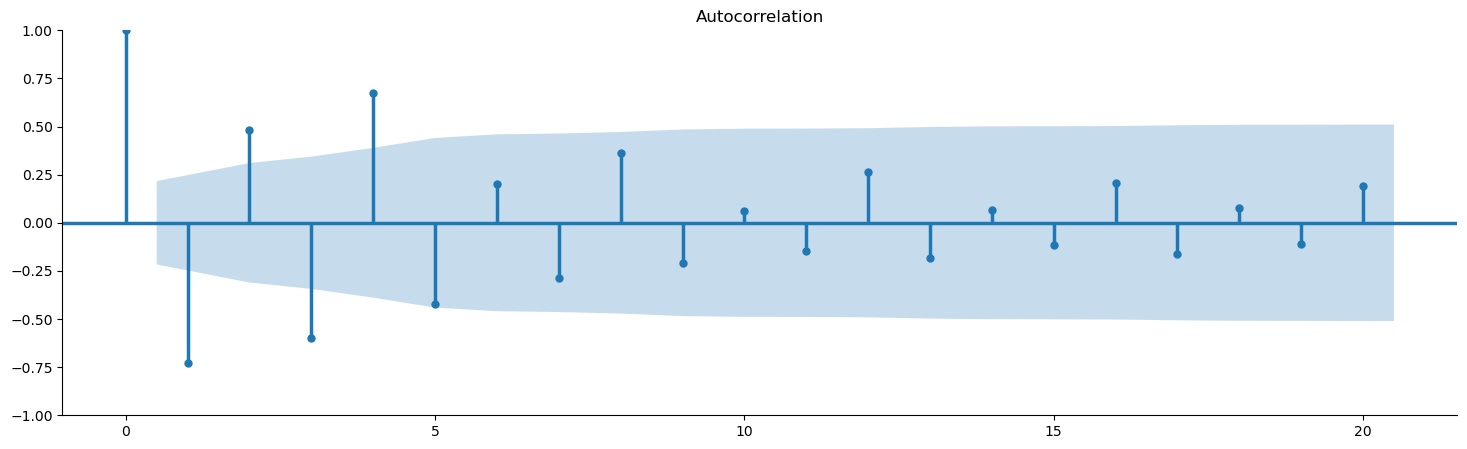

In [359]:
plot_acf(eps_diff2)
plt.show()

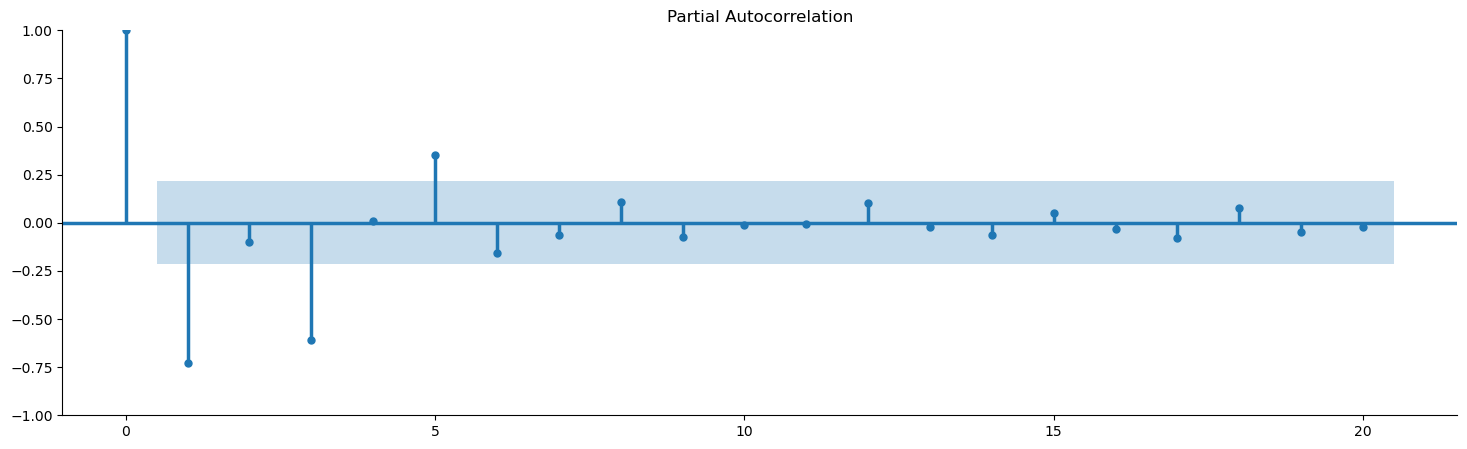

In [360]:
plot_pacf(eps_diff2)
plt.show()

### AIC Criteria for best order selection

In [361]:
from tqdm import tqdm
import pandas as pd
from itertools import product
from statsmodels.tsa.arima.model import ARIMA

def optimize_arima(endog, order_list, d):
    results = []
    
    for order in tqdm(order_list, desc="Optimizing ARIMA models"):
        try:
            # Fit ARIMA model
            model = ARIMA(
                endog, 
                order=(order[0], d, order[1])
            ).fit()
        except Exception as e:
            print(f"Model {order} failed with error: {e}")
            continue
        
        # Collect AIC for the model
        aic = model.aic
        results.append([order, aic])
        
    # If no valid models were found
    if not results:
        print("No valid models were found.")
        return pd.DataFrame()
    
    # Create a DataFrame with results
    result_df = pd.DataFrame(results, columns=['(p, q)', 'AIC'])
    
    # Sort in ascending order based on AIC
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [362]:
from itertools import product

p_range = range(0, 4, 1)
q_range = range(0, 4, 1)
d = 0

myorder_list = list(product(p_range, q_range))

In [363]:
# Ensure the function name is correct
result_df = optimize_arima(df_diff, myorder_list, d)
result_df

Optimizing ARIMA models: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s]


,"(p, q)",AIC
0,"(3, 3)",114.257663
1,"(3, 2)",119.505809
2,"(3, 1)",123.030460
3,"(3, 0)",162.730028
4,"(0, 3)",214.354185
5,"(2, 2)",234.994642
6,"(1, 2)",236.443248
7,"(0, 2)",243.461766
8,"(2, 3)",248.194747
9,"(1, 3)",256.516779


## Train ARIMA Model

In [364]:
model = ARIMA(train, order=(3,2,3))
model_fit = model.fit()
residuals = model_fit.resid

In [365]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   75
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 -23.649
Date:                Sat, 15 Feb 2025   AIC                             61.299
Time:                        06:46:27   BIC                             77.332
Sample:                             0   HQIC                            67.688
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0979      0.058    -18.861      0.000      -1.212      -0.984
ar.L2         -1.0695      0.040    -26.759      0.000      -1.148      -0.991
ar.L3         -0.9446      0.042    -22.679      0.0

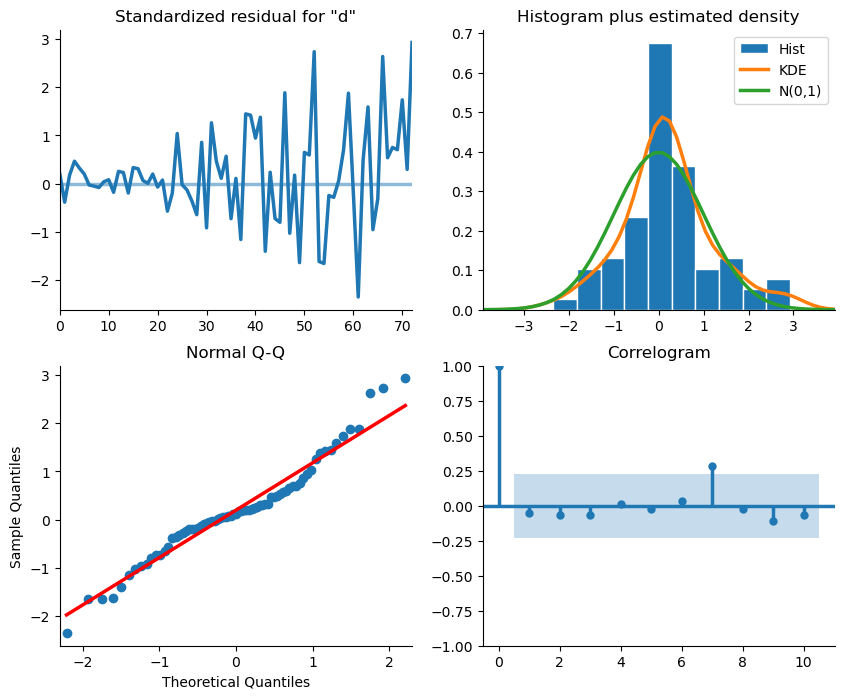

In [366]:
model_fit.plot_diagnostics(figsize=(10, 8));

# 🔹 Step 6: Model Evaluation
.

## 🔹 Evaluate Model on Test Data

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [368]:
test

,data,pred_mean,pred_last
date,,,
1978-10-01,8.91,3.785733,12.15
1979-01-01,14.04,3.785733,12.15
1979-04-02,12.96,3.785733,12.15
1979-07-02,14.85,3.785733,12.15
1979-10-01,9.99,3.785733,12.15
1980-01-01,16.20,3.785733,12.15
1980-04-01,14.67,3.785733,12.15
1980-07-02,16.02,3.785733,12.15
1980-10-01,11.61,3.785733,12.15


In [381]:
forecast_test = model_fit.get_prediction(start=len(train), end=len(train)+len(test)-1,dynamic=False)


In [382]:
forecast_mean_test=forecast_test.predicted_mean.to_frame()

# Manually assign test index
forecast_mean_test.index = test.index  # Ensure it matches the test set
forecast_mean_test

,predicted_mean
date,
1978-10-01,11.532573
1979-01-01,14.424717
1979-04-02,14.288959
1979-07-02,14.392538
1979-10-01,14.156426
1980-01-01,16.897470
1980-04-01,16.506983
1980-07-02,16.691645
1980-10-01,16.781661


In [371]:
confidence_intervals_test=forecast_test.conf_int()


confidence_intervals_test.index = test.index  # Ensure it matches the test set
confidence_intervals_test

,lower data,upper data
date,,
1978-10-01,10.913491,12.151656
1979-01-01,13.679869,15.169565
1979-04-02,13.470244,15.107675
1979-07-02,13.477903,15.307173
1979-10-01,12.831785,15.481067
1980-01-01,15.397670,18.397269
1980-04-01,14.859288,18.154677
1980-07-02,14.855638,18.527653
1980-10-01,14.540663,19.022659


In [372]:
df.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


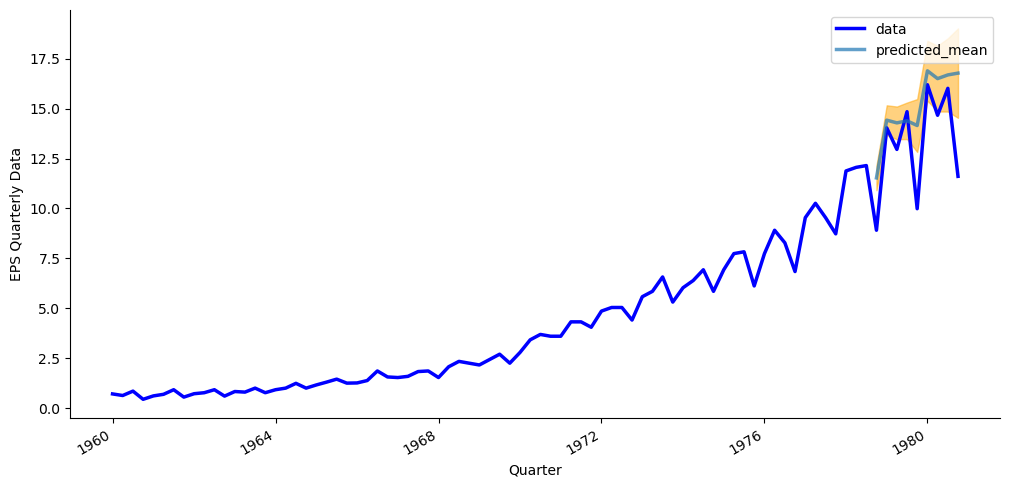

In [373]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# 1️⃣ Plot the full original series
df.plot(ax=ax, label="Original Data", color="blue")


forecast_mean_test.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)
ax.fill_between(confidence_intervals_test.index, confidence_intervals_test.iloc[:, 0], confidence_intervals_test.iloc[:, 1], color='orange', alpha=.5)

ax.set_xlabel('Quarter')
ax.set_ylabel('EPS Quarterly Data')
plt.legend(loc='best')
plt.show()


In [374]:
# Calculate test error
mae_os_test = mean_absolute_error(test['data'], forecast_mean_test)
print(f"Test Data (Dynamic) MAE: {mae_os_test:.3f}")


Test Data (Dynamic) MAE: 1.926


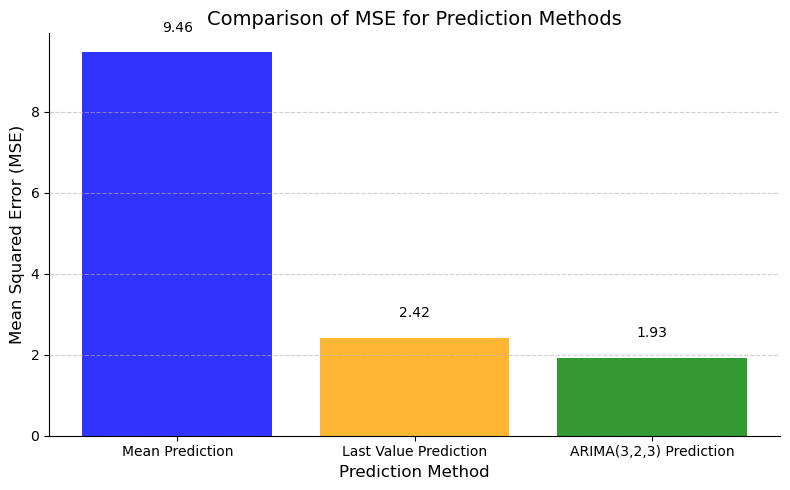

In [375]:
# Store in a list
mae_values = [mae_mean, mae_last, mae_os_test]

methods = ['Mean Prediction', 'Last Value Prediction', 'ARIMA(3,2,3) Prediction']

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(methods, mae_values, color=['blue', 'orange', 'green'], alpha=0.8)

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}', ha='center', fontsize=10)

# Set labels and title
ax.set_xlabel('Prediction Method', fontsize=12)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax.set_title('Comparison of MSE for Prediction Methods', fontsize=14)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# 🔹 Step 7: Forecast Future EPS Data

## Case - Forecasting Data of next Quarter(Short Term)

In [387]:
# one step ahead forecast - uses actual data
forecast_onequareter = model_fit.get_prediction(start=len(df), dynamic=False)
forecast_mean_oq=forecast_onequareter.predicted_mean.to_frame()
forecast_mean_oq

,0
84,19.318537


In [390]:
#method only uses past observed data
forecast_onequareter = model_fit.get_forecast(steps=10)
forecast_mean_oq=forecast_onequareter.predicted_mean.to_frame()
forecast_mean_oq

,predicted_mean
75,11.532573
76,14.424717
77,14.288959
78,14.392538
79,14.156426
80,16.897470
81,16.506983
82,16.691645
83,16.781661
84,19.318537


In above 2 cases we can extract , confidence intervals.In below case only point forecast is obtained

In [391]:
#method only uses past observed data
forecast_onequareter = model_fit.forecast(steps=10)
forecast_onequareter

75    11.532573
76    14.424717
77    14.288959
78    14.392538
79    14.156426
80    16.897470
81    16.506983
82    16.691645
83    16.781661
84    19.318537
Name: predicted_mean, dtype: float64

## Case - Forecasting Data of next 2 Years- next 8 quarters(Long Term)

In [394]:
forecast_8quareter = model_fit.forecast(steps=17)
forecast_8quareter

75    11.532573
76    14.424717
77    14.288959
78    14.392538
79    14.156426
80    16.897470
81    16.506983
82    16.691645
83    16.781661
84    19.318537
85    18.726840
86    19.042708
87    19.396711
88    21.693489
89    20.959145
90    21.439045
91    21.992303
Name: predicted_mean, dtype: float64

In [404]:

last_train_index = train.index[-1]  # Last date in training data

# Generate future timestamps for 17 quarters ahead
future_dates = pd.date_range(start=last_train_index, periods=18, freq='Q')[1:]  # Exclude last train date

# Convert forecasted values into a Pandas Series with the new index
forecast_series = pd.Series(forecast_8quareter.values, index=future_dates)
forecast_series


1978-12-31    11.532573
1979-03-31    14.424717
1979-06-30    14.288959
1979-09-30    14.392538
1979-12-31    14.156426
1980-03-31    16.897470
1980-06-30    16.506983
1980-09-30    16.691645
1980-12-31    16.781661
1981-03-31    19.318537
1981-06-30    18.726840
1981-09-30    19.042708
1981-12-31    19.396711
1982-03-31    21.693489
1982-06-30    20.959145
1982-09-30    21.439045
1982-12-31    21.992303
Freq: QE-DEC, dtype: float64

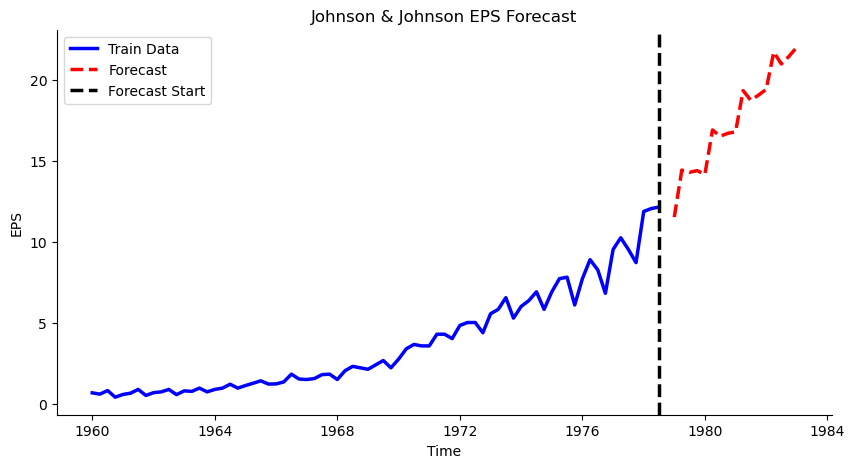

In [407]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train, label="Train Data", color='blue')
plt.plot(forecast_series, label="Forecast", color='red', linestyle='dashed')
plt.axvline(x=last_train_index, color='black', linestyle='--', label="Forecast Start")
plt.legend()
plt.xlabel("Time")
plt.ylabel("EPS")
plt.title("Johnson & Johnson EPS Forecast")
plt.show()

If we use get_forecast - it will give confidence interval

# What Next

- Model Improvement - We have not addressed seasonality and  variance in data .Need to apply method like box cox before training for variance and try model like SARIMA.Further revert back data to original after fitting

- In real life since you receive new data every quarter, you should adopt a rolling forecasting approach, where you:

✅ Automate the process for continuous forecasting.

✅  Train the model on available data.

✅  Forecast the next quarter.

✅  Compare the forecast with actual data when it arrives.

✅  Update the model with the new data and repeat.